# 1. Modeling & Simulation

In [1]:
# imports
import sys
sys.path.append('..')
from estim8.models import FmuModel
from estim8.visualization import plot_simulation

## 1.1. Mathematical model formulation
The workflow is demonstrated using a simple *Ordinary Differential Equation* (ODE) model from the field of biotechnology.

Here, growth of a microbial strain (biomass) in batch culture can be described in the form 

\begin{equation}
    \frac{d}{dt} X(t) = \mu(t) \cdot X(t), \quad \quad X(t=0)=X_{0}
    \tag{1}        
\end{equation}

where the biomass is denoted as $X(t)~[g~L^{-1}]$ with initial concentration $X_{0}$, and the specific growth rate is denoted as $\mu(t)~[h^{-1}]$.

By taking a *black-box* approach and assuming a single finite carbon and energy source denoted as $S(t)~[g~L^{-1}]$, the growth rate can be modelled by a *Monod*-type kinetic in the form  

\begin{equation}
    \mu(t) = \mu_{max} \cdot \frac{S(t)}{S(t)+K_S}
    \tag{2}  
\end{equation}

where $\mu_{max}~[h^{-1}]$ denotes the strain and substrate specific maximum growth rate, and $K_S~[g~L^{-1}]$ the half-maximum saturation constant.

The depletetion of $S(t)$ in dependence of microbial growth can then be modelled as

\begin{equation}
    \frac{d}{dt} S(t) = \frac{-\mu(t) \cdot X(t)}{Y_{XS}}, \quad \quad S(t=0)=S_{0}
    \tag{3} 
\end{equation}

where $Y_{XS}~[g_X~g_S^-1]$ denotes the biomass specific yield coefficient.

## 1.2. Model implementation
The model is implemented using the modeling language [Modelica](https://modelica.org/) as shown below. [OpenModelica](https://openmodelica.org/) offers an open-source and interactive environment for this purpose. 

```modelica
model SimpleBatch
  
  // define real states
  Real X(start = X0, fixed = true);
  Real S(start = S0, fixed = true);
  Real mu;

  // define variables
  parameter Real X0 = 0.1;
  parameter Real S0 = 10;
  parameter Real mu_max = 0.5;
  parameter Real Ks = 0.01;
  parameter Real Y_XS = 0.5;

equation
  der(X) = mu*X;
  der(S) = -mu*X/Y_XS;
  mu = mu_max*S/(Ks + S);

// prevent negative states
if (S<=0) then
  S=0;
 end if;
 
end SimpleBatch;
```

To apply this model with `estim8`, it has to be exported as a _Functional Mockup Unit_ (FMU). Both FMI types _Co-Simulation_ and _Model-Exchange_ are supported.

## 1.3. Simulation with `estim8.FmuModel`

The `FmuModel` class offers a Python-based simulation interface for FMUs. For initialization, simply pass the FMU's filepath. Additional keyword arguments are:

| Kwarg | type | description |
| ----- |----- |------------ |
| fmi_type | str | The FMI type used for Simulation. Supported are "ModelExchange" (default) and "CoSimulation". |
| default_parameters | dict | A dictionary in form {"param": val} to define default parameters. |
| r_tol | float | Relative tolerance for the 'CVode' solver and co-simulation of FMUs. Default is $1e^{-4}$.|

In [2]:
SimpleBatchModel = FmuModel(r'../tests/test_data/SimpleBatch.fmu')

### 1.3.1. Managing model properties

#### Model parameters 
The `parameters` are accessible in form of a dictionary via the class property. To change model parameters, simply redefine the values of parameter keys.

In [3]:
print('Parameters before: \n', SimpleBatchModel.parameters)
# change a single parameter, e.g. mu_max 
SimpleBatchModel.parameters['mu_max'] = 0.4
print("\nParameters after changing:\n", SimpleBatchModel.parameters)

Parameters before: 
 {'Ks': 0.01, 'S0': 10.0, 'X0': 0.2, 'Y_XS': 0.35, 'mu_max': 0.4}

Parameters after changing:
 {'Ks': 0.01, 'S0': 10.0, 'X0': 0.2, 'Y_XS': 0.35, 'mu_max': 0.4}


#### Simulation flags
Both `fmi_type` and `r_tol` can be changed using the property setter methods.

In [4]:
print(f'Before:\n FMI type: {SimpleBatchModel.fmi_type},  r_tol={SimpleBatchModel.r_tol}')
# change both values
# SimpleBatchModel.fmi_type = 'CoSimulation'
SimpleBatchModel.r_tol = 1e-8

print(f'After:\n FMI type: {SimpleBatchModel.fmi_type},  r_tol={SimpleBatchModel.r_tol}')


Before:
 FMI type: ModelExchange,  r_tol=0.0001
After:
 FMI type: ModelExchange,  r_tol=1e-08


### 1.3.2. Forward simulation

The model can be simulated using the class method `simulate`, which at least requires the following arguments:

| arg  | type  |  description |
| ----  | ----  |     ----     |
| t0    | float | Start time of the simulation  |
| t_end | float | End time of the simulation    |
| stepsize | float | Stepsize of the DAE solver |

Additional keyword arguments comprise:

| kwarg  | type  |  description |
| ----  | ----  |     ----     |
| parameters | dict[float] | Parameters applied in simulation. If not specified, the class property `parameters` are used. |
| observe | list[str] | Quantitites to observe. Default is None, which means all *observable* quantities within the model are used. |
| r_tol   | float | Relative solver tolerance. Default is None, which means the class property `r_tol` is used. |
| solver | str | Solver to use in ModelExchange. Default is Cvode. |
| replicate_ID | str\|None | Replicate ID. Default is `None`. |

The method returns a `Simulation` object, which contains a list of `ModelPredictions`.

In [5]:
# simulation using default values and settings
simulation = SimpleBatchModel.simulate(
    t0= 0,
    t_end= 10,
    stepsize=0.1,
    )

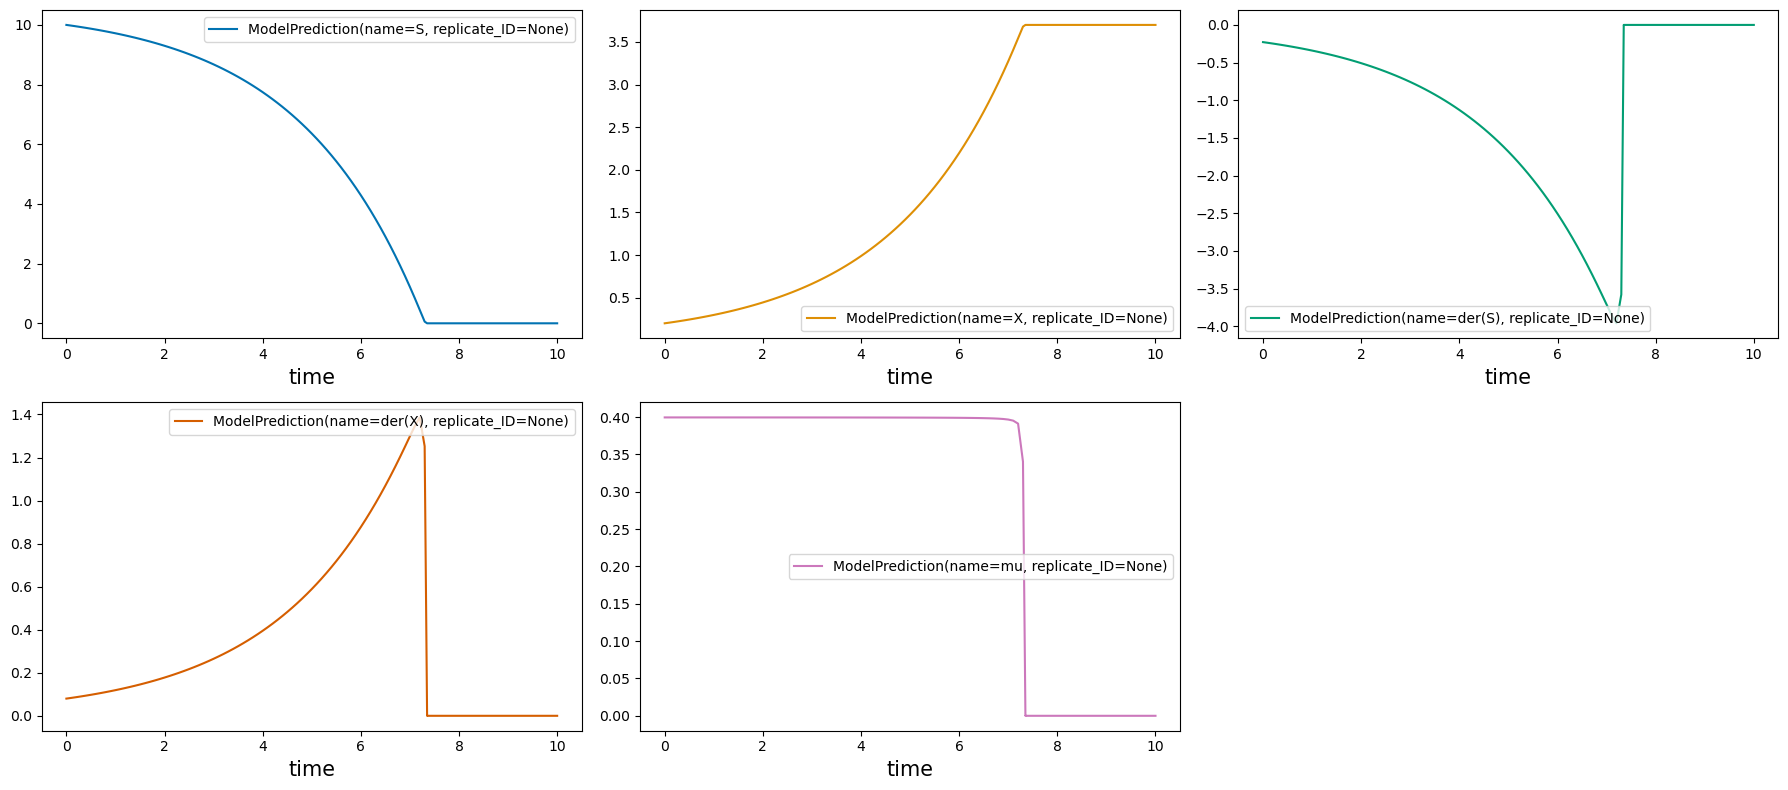

In [6]:
_ = plot_simulation(simulation=simulation, observe=None)